In [4]:


conda install pytorch torchvision -c pytorch

Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/leandrenash/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/leandrenash/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1



## Package Plan ##

  environment location: /Users/leandrenash/anaconda3/envs/myvirutalenv

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------

In [6]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd

In [22]:
# Re-import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
MAX_LEN = 128

def encode_sequences(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True
    )

train_encodings = encode_sequences(X_train)
test_encodings = encode_sequences(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(y_test)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Data and model reloaded.")

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weigh

Data and model reloaded.


In [24]:
import torch
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim

# Assume you have a list or array of labels for the training set
# This is usually something like train_labels in the dataset
labels = [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]  # Replace with your actual training labels

# Compute class weights
class_weights = compute_class_weight('balanced', classes=torch.unique(torch.tensor(labels)).numpy(), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define the weighted loss function
loss_fn = CrossEntropyLoss(weight=class_weights)

# Optimizer
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with weighted loss
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} completed with average loss: {avg_loss:.4f}')

print("Training completed.")


Epoch 1/5 completed with average loss: 0.6163
Epoch 2/5 completed with average loss: 0.5760
Epoch 3/5 completed with average loss: 0.5045
Epoch 4/5 completed with average loss: 0.4020
Epoch 5/5 completed with average loss: 0.2969
Training completed.


Classification Report (Fine-tuned BERT):
              precision    recall  f1-score   support

  Response A       0.71      0.85      0.77        52
  Response B       0.73      0.55      0.63        40

    accuracy                           0.72        92
   macro avg       0.72      0.70      0.70        92
weighted avg       0.72      0.72      0.71        92



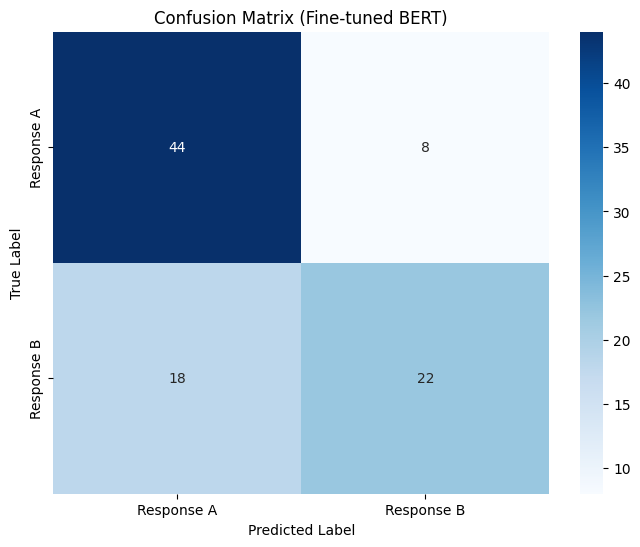

Evaluation completed.


In [25]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (Fine-tuned BERT):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuned BERT)')
plt.show()

print("Evaluation completed.")

Epoch 1/5 completed with average loss: 0.0802
Epoch 2/5 completed with average loss: 0.0362
Epoch 3/5 completed with average loss: 0.0160
Epoch 4/5 completed with average loss: 0.0092
Epoch 5/5 completed with average loss: 0.0090
Training with Focal Loss completed.
Classification Report (BERT with Focal Loss):
              precision    recall  f1-score   support

  Response A       0.70      0.94      0.80        52
  Response B       0.86      0.47      0.61        40

    accuracy                           0.74        92
   macro avg       0.78      0.71      0.71        92
weighted avg       0.77      0.74      0.72        92



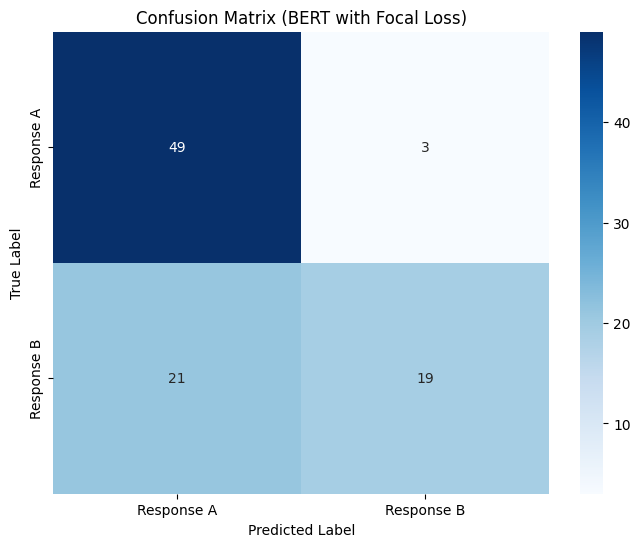

Evaluation completed.


In [26]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Initialize focal loss
focal_loss = FocalLoss(alpha=1, gamma=2)

# Optimizer
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with focal loss
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = focal_loss(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} completed with average loss: {avg_loss:.4f}')

print("Training with Focal Loss completed.")

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (BERT with Focal Loss):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT with Focal Loss)')
plt.show()

print("Evaluation completed.")

Classification Report (BERT with Focal Loss):
              precision    recall  f1-score   support

  Response A       0.70      0.94      0.80        52
  Response B       0.86      0.47      0.61        40

    accuracy                           0.74        92
   macro avg       0.78      0.71      0.71        92
weighted avg       0.77      0.74      0.72        92



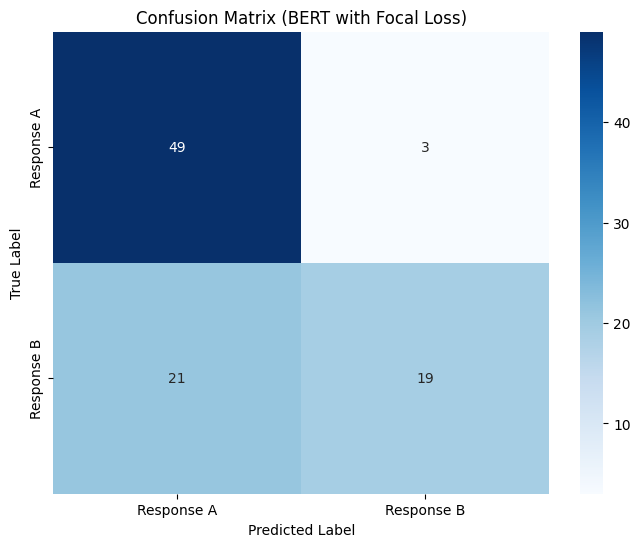

Evaluation completed.


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print("\
Classification Report (BERT with Focal Loss):")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT with Focal Loss)')
plt.show()

print("Evaluation completed.")

In [28]:
# Define a function to predict the class of a single job description
def predict_job_description(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    return predicted_label

# Test the function with a sample job description
sample_job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label = predict_job_description(sample_job_description)

print("Predicted label for the sample job description:", predicted_label)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predicted label for the sample job description: Response A


In [30]:
def predict_job_description(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    return predicted_label

# Example usage
job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label = predict_job_description(job_description)
print("Predicted label:", predicted_label)

Predicted label: Response A


In [32]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "We are looking for a skilled software engineer with experience in Python and machine learning."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.7930759


In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "Design sketches of the mass media announcement."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.5713932


In [2]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
MAX_LEN = 128

def encode_sequences(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True
    )

train_encodings = encode_sequences(X_train)
test_encodings = encode_sequences(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(y_test)
)

# Hyperparameter tuning
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
epochs_list = [3, 4, 5]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}")
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Load pre-trained BERT model
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

            # Set device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model.to(device)

            # Optimizer
            optimizer = AdamW(model.parameters(), lr=lr)

            # Training loop
            for epoch in range(epochs):
                model.train()
                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                    optimizer.zero_grad()
                    input_ids = batch[0].to(device)
                    attention_mask = batch[1].to(device)
                    labels = batch[2].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            predictions = []
            true_labels = []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch[0].to(device)
                    attention_mask = batch[1].to(device)
                    labels = batch[2].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask)
                    _, preds = torch.max(outputs.logits, dim=1)
                    predictions.extend(preds.cpu().tolist())
                    true_labels.extend(labels.cpu().tolist())

            accuracy = accuracy_score(true_labels, predictions)
            print(f"Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

print(f"Best accuracy: {best_accuracy:.4f}")
print(f"Best parameters: {best_params}")

# Save the best model
torch.save(model.state_dict(), 'best_bert_model.pth')
print("Best model saved as 'best_bert_model.pth'")

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [09:20<00:00, 24.39s/it]


Accuracy: 0.5870
Training with lr=2e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [08:01<00:00, 20.95s/it]


Accuracy: 0.6630
Training with lr=2e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [13:37<00:00, 35.53s/it]


Accuracy: 0.7174
Training with lr=2e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [07:58<00:00, 39.84s/it]


Accuracy: 0.6522
Training with lr=2e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [14:11<00:00, 70.95s/it]


Accuracy: 0.7065
Training with lr=2e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [12:08<00:00, 60.74s/it]


Accuracy: 0.6630
Training with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [12:05<00:00, 31.56s/it]


Accuracy: 0.7391
Training with lr=3e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [14:51<00:00, 38.74s/it]


Accuracy: 0.7717
Training with lr=3e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [12:02<00:00, 31.39s/it]


Accuracy: 0.6196
Training with lr=3e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [12:01<00:00, 60.09s/it]


Accuracy: 0.7283
Training with lr=3e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [10:55<00:00, 54.59s/it]


Accuracy: 0.6739
Training with lr=3e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [08:24<00:00, 42.07s/it]


Accuracy: 0.6630
Training with lr=5e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 23/23 [08:01<00:00, 20.94s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 23/23 [11:04<00:00, 28.87s/it]


Accuracy: 0.7065
Training with lr=5e-05, batch_size=16, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 23/23 [09:48<00:00, 25.58s/it]


Accuracy: 0.7717
Training with lr=5e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 12/12 [07:49<00:00, 39.09s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4/4: 100%|██████████| 12/12 [07:44<00:00, 38.73s/it]


Accuracy: 0.6957
Training with lr=5e-05, batch_size=32, epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 12/12 [08:43<00:00, 43.61s/it]


Accuracy: 0.7391
Best accuracy: 0.7717
Best parameters: {'lr': 3e-05, 'batch_size': 16, 'epochs': 4}
Best model saved as 'best_bert_model.pth'


In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn.functional as F

# Load the data
df = pd.read_csv('data_new.csv', encoding='UTF-8-SIG')

# Prepare the data
X = df['Job Description'].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_job_description_with_score(job_description):
    model.eval()
    with torch.no_grad():
        # Tokenize and encode the job description
        encoding = tokenizer.encode_plus(
            job_description,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probabilities, dim=1)

    # Decode the prediction
    predicted_label = le.inverse_transform(prediction.cpu().numpy())[0]
    score = score.cpu().numpy()[0]
    return predicted_label, score

# Example usage
job_description = "Develop and implement effective communications activities for external customers and stakeholders."
predicted_label, score = predict_job_description_with_score(job_description)
print("Predicted label:", predicted_label)
print("Score:", score)

/Users/leandrenash/anaconda3/envs/myvirutalenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Response A
Score: 0.6714815
